In [113]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['PATH'] = '/tools/Xilinx/Vitis_HLS/2021.2/bin' + os.environ['PATH']

In [114]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [115]:
print(X_train.shape)

(60000, 28, 28)


In [116]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [117]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

def normalize(image):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255.

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [118]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [119]:
X_test_norm = np.array([normalize(im) for im in list(X_test)])


In [120]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

In [121]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [122]:
model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 [==============================] - 9s 10ms/step - loss: 0.6273 - sparse_categorical_accuracy: 0.8263 - val_loss: 0.1888 - val_sparse_categorical_accuracy: 0.9463
Epoch 2/6
469/469 [==============================] - 3s 6ms/step - loss: 0.1736 - sparse_categorical_accuracy: 0.9504 - val_loss: 0.1372 - val_sparse_categorical_accuracy: 0.9613
Epoch 3/6
469/469 [==============================] - 3s 7ms/step - loss: 0.1187 - sparse_categorical_accuracy: 0.9665 - val_loss: 0.1133 - val_sparse_categorical_accuracy: 0.9663
Epoch 4/6
469/469 [==============================] - 3s 6ms/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9731 - val_loss: 0.0929 - val_sparse_categorical_accuracy: 0.9724
Epoch 5/6
469/469 [==============================] - 3s 7ms/step - loss: 0.0693 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.0911 - val_sparse_categorical_accuracy: 0.9719
Epoch 6/6
469/469 [==============================] - 3s 6ms/step - loss: 0.0591 - sparse_categorical_acc

In [123]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
# plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')

Interpreting Sequential
Topology:
Layer name: flatten_6_input, layer type: Input
Layer name: dense_12, layer type: Dense
  -> Activation (relu), layer name: dense_12
Layer name: dense_13, layer type: Dense
  -> Activation (linear), layer name: dense_13
-----------------------------------
Configuration
-----------------------------------
Interpreting Sequential
Topology:
Layer name: flatten_6_input, layer type: InputLayer, input shapes: [[None, 28, 28]], output shape: [None, 28, 28]
Layer name: flatten_6, layer type: Reshape, input shapes: [[None, 28, 28]], output shape: [None, 784]
Layer name: dense_12, layer type: Dense, input shapes: [[None, 784]], output shape: [None, 128]
Layer name: dense_13, layer type: Dense, input shapes: [[None, 128]], output shape: [None, 10]
Creating HLS model


In [124]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [125]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test_norm)
y_hls = hls_model.predict(X_test_norm)

Writing HLS project
Done


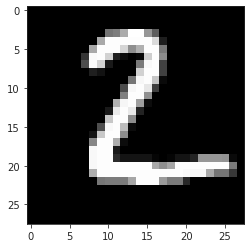

[ -4.3569      4.935482   11.826595    2.6929393 -13.501325   -0.1435949
  -2.383676  -10.909       0.4189981 -13.909458 ] [ -4.1904297    4.78125     11.124023     2.477539   -12.692383
  -0.19824219  -2.4746094  -10.474609     0.38085938 -13.233398  ]


In [126]:
results = model.predict(X_test)

# pick a sample to plot
image = X_test[1]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

print(results[1], y_hls[1])

In [127]:
hls_model.build(csim=False)

Exception: Vivado HLS installation not found. Make sure "vivado_hls" is on PATH.

In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')